# Dynamic Mode Decomposition

In this notebook, we are applying DMD to data with different modalities.

In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import utilities as util

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [2]:
def DMD(data, r):
    """
        Dynamic Mode Decomposition (DMD) algorithm.
    """
    ## Build data matrices
    X1 = data[:, :-1]
    X2 = data[:, 1:]
    
    ## Perform singular value decomposition on X1
    U, S, V = np.linalg.svd(X1, full_matrices = False)
    
    ## Compute estimated Koopman operator
    A_tilde = U[:, :r].conj().T @ X2 @ V[:r, :].conj().T * np.reciprocal(S[:r])
    
    ## Perform eigenvalue decomposition on A_tilde
    Phi, Q = np.linalg.eig(A_tilde)
    
    ## Compute coefficient matrix
    Psi = X2 @ V[:r, :].conj().T @ np.diag(np.reciprocal(S[:r])) @ Q
    A = Psi @ np.diag(Phi) @ np.linalg.pinv(Psi)
    
    return A_tilde, Phi, A

In [3]:
def DMD_forecast(data, r, t):
    N, T = data.shape
    
    _, _, A = DMD(data, r)
    
    mat = np.append(data, np.zeros((N, t)), axis=1)
    
    for s in range(t):
        mat[:, T + s] = (A @ mat[:, T + s - 1]).real
        
    return mat[:, -t:]

In [4]:
data_path = "../Processed_Data/"

## Stocks Data

In [5]:
stocks_data = pd.read_csv(os.path.join(data_path, 'etf_data.csv'), index_col='datetime').iloc[:3000].reset_index(drop=True)

### Hyperparameter Tuning

In [29]:
train_index_begin = 2100
prediction_horizon = 10

# Subsampling dimension
rs = range(1, stocks_data.shape[1]+1)
final_rmspe = pd.DataFrame()

for r in rs:
    
    # To hold forecasted values
    final_forecasts = pd.DataFrame()

    # Rolling training
    for train_end in list(range(train_index_begin, stocks_data.shape[0], prediction_horizon)):
        train_start = train_end - 150
        test_start = train_end + 1
        test_end = test_start + prediction_horizon

        if test_end >= stocks_data.shape[0]:
            continue

        train_data = stocks_data.iloc[train_start:train_end, :]
        test_data = stocks_data.iloc[test_start:test_end, :]

        dmd_input = np.array(train_data).T
        dmd_forecast = DMD_forecast(dmd_input, r, prediction_horizon)
        forecasted_data = pd.DataFrame(dmd_forecast.T, columns=test_data.columns, index=test_data.index)

        if final_forecasts.shape[0] == 0:
            final_forecasts = forecasted_data
        else:
            final_forecasts = pd.concat([final_forecasts, forecasted_data])

    true_data = stocks_data[stocks_data.index.isin(final_forecasts.index)]
    rmspe_values = util.rmspe(final_forecasts, true_data)
    rmspe_values['Subsampling Dimension'] = r
    
    final_rmspe = pd.concat([final_rmspe, pd.DataFrame([rmspe_values])]).reset_index(drop=True)

In [30]:
final_rmspe

,DIA,EEM,QQQ,SPY,VXX,Subsampling Dimension
0,0.127160,0.246594,0.229368,0.102315,0.826800,1
1,0.092675,0.185920,0.148075,0.097116,0.430309,2
2,0.093710,0.168359,0.151703,0.102172,0.303091,3
3,0.142876,0.211356,0.243416,0.145411,0.306240,4
4,0.149358,0.179288,0.239273,0.149466,0.318303,5


In [31]:
r = 2

In [34]:
train_index_begin = 2100
prediction_horizon = 10

# To hold forecasted values
final_forecasts = pd.DataFrame()

# Rolling training
for train_end in list(range(train_index_begin, stocks_data.shape[0], prediction_horizon)):
    train_start = train_end - 150
    test_start = train_end + 1
    test_end = test_start + prediction_horizon

    if test_end >= stocks_data.shape[0]:
        continue

    train_data = stocks_data.iloc[train_start:train_end, :]
    test_data = stocks_data.iloc[test_start:test_end, :]

    dmd_input = np.array(train_data).T
    dmd_forecast = DMD_forecast(dmd_input, r, prediction_horizon)
    forecasted_data = pd.DataFrame(dmd_forecast.T, columns=test_data.columns, index=test_data.index)

    if final_forecasts.shape[0] == 0:
        final_forecasts = forecasted_data
    else:
        final_forecasts = pd.concat([final_forecasts, forecasted_data])

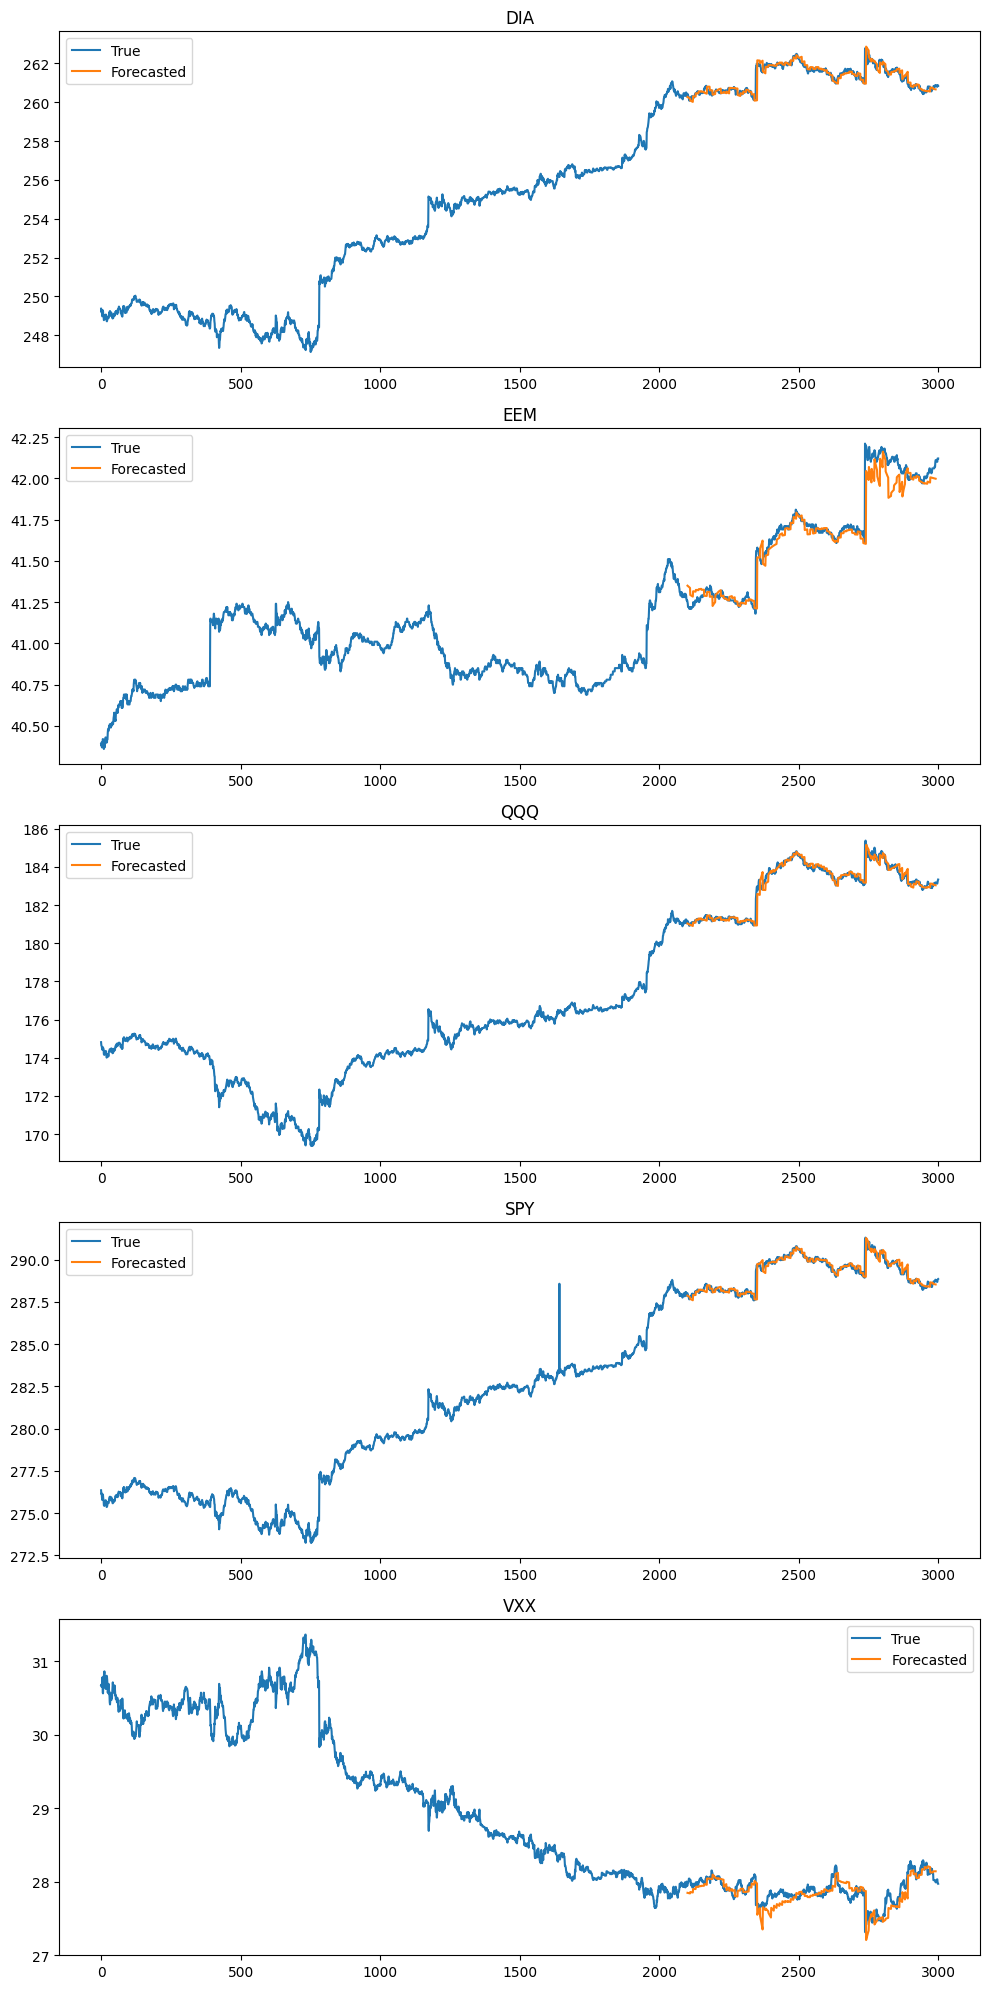

In [35]:
n_plots = stocks_data.shape[1]

fig, axs = plt.subplots(n_plots, 1, figsize=(10, 20))

for i, column in enumerate(stocks_data.columns):
    ax = axs[i]
    
    ax.plot(stocks_data[column])
    ax.plot(final_forecasts[column])
    ax.legend(['True', 'Forecasted'])
    ax.set_title(column)
    
plt.tight_layout()

## GDP Data

In [23]:
gdp_data = pd.read_csv(os.path.join(data_path, 'gdp_data.csv'), index_col='DATE').reset_index(drop=True)

In [36]:
train_index_begin = 150
prediction_horizon = 5

# Subsampling dimension
rs = range(1, gdp_data.shape[1]+1)
final_rmspe = pd.DataFrame()

for r in rs:
    
    # To hold forecasted values
    final_forecasts = pd.DataFrame()

    # Rolling training
    for train_end in list(range(train_index_begin, gdp_data.shape[0], prediction_horizon)):
        train_start = train_end - 150
        test_start = train_end + 1
        test_end = test_start + prediction_horizon

        if test_end >= gdp_data.shape[0]:
            continue

        train_data = gdp_data.iloc[train_start:train_end, :]
        test_data = gdp_data.iloc[test_start:test_end, :]

        dmd_input = np.array(train_data).T
        dmd_forecast = DMD_forecast(dmd_input, r, prediction_horizon)
        forecasted_data = pd.DataFrame(dmd_forecast.T, columns=test_data.columns, index=test_data.index)

        if final_forecasts.shape[0] == 0:
            final_forecasts = forecasted_data
        else:
            final_forecasts = pd.concat([final_forecasts, forecasted_data])

    true_data = gdp_data[gdp_data.index.isin(final_forecasts.index)]
    rmspe_values = util.rmspe(final_forecasts, true_data)
    rmspe_values['Subsampling Dimension'] = r
    
    final_rmspe = pd.concat([final_rmspe, pd.DataFrame([rmspe_values])]).reset_index(drop=True)

In [37]:
final_rmspe

,Tbill,PPINSA,CPI,M1NSA,Unemp,IndProd,RGDP,Subsampling Dimension
0,10110.287103,9.392372,5.157835,15.869542,84.652296,9.860042,2.034810,1
1,5668.938851,11.109852,2.833643,5.797884,68.299149,8.231873,2.056031,2
2,3702.111446,7.650044,4.504732,5.532146,52.844029,8.121466,2.001900,3
3,3230.179988,6.928938,2.460181,5.337094,40.427888,8.447450,1.974979,4
4,5692.708018,7.942230,2.104370,5.062285,40.193955,5.018176,1.930343,5
5,5255.853130,8.264468,2.167478,5.354333,19.705314,3.898052,1.593579,6
6,2993.840850,8.684249,2.157081,5.234764,16.828141,3.836193,1.582985,7


In [38]:
r = 7

In [39]:
train_index_begin = 150
prediction_horizon = 5
    
# To hold forecasted values
final_forecasts = pd.DataFrame()

# Rolling training
for train_end in list(range(train_index_begin, gdp_data.shape[0], prediction_horizon)):
    train_start = train_end - 150
    test_start = train_end + 1
    test_end = test_start + prediction_horizon

    if test_end >= gdp_data.shape[0]:
        continue

    train_data = gdp_data.iloc[train_start:train_end, :]
    test_data = gdp_data.iloc[test_start:test_end, :]

    dmd_input = np.array(train_data).T
    dmd_forecast = DMD_forecast(dmd_input, r, prediction_horizon)
    forecasted_data = pd.DataFrame(dmd_forecast.T, columns=test_data.columns, index=test_data.index)

    if final_forecasts.shape[0] == 0:
        final_forecasts = forecasted_data
    else:
        final_forecasts = pd.concat([final_forecasts, forecasted_data])

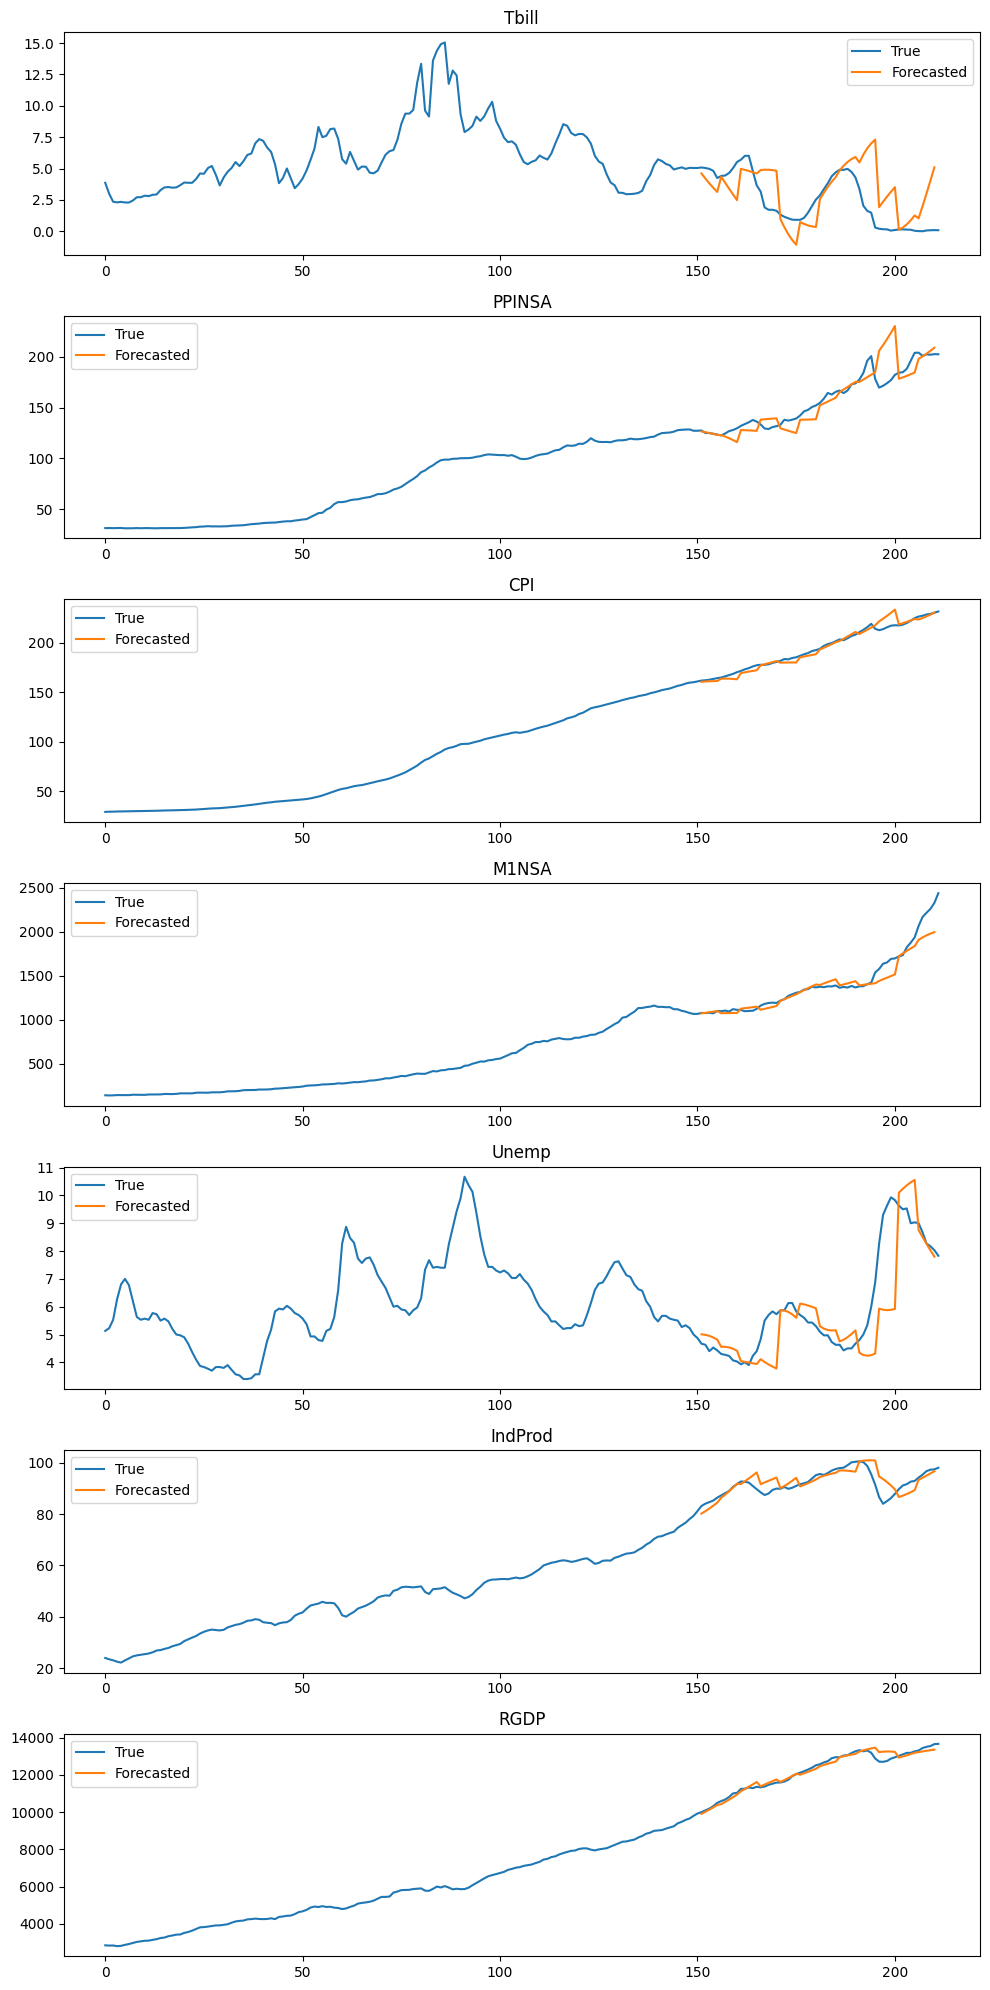

In [40]:
n_plots = gdp_data.shape[1]

fig, axs = plt.subplots(n_plots, 1, figsize=(10, 20))

for i, column in enumerate(gdp_data.columns):
    ax = axs[i]
    
    ax.plot(gdp_data[column])
    ax.plot(final_forecasts[column])
    ax.legend(['True', 'Forecasted'])
    ax.set_title(column)
    
plt.tight_layout()